### Imports

In [2]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH, STOCKS_DATA_PATH, FOREX_DATA_PATH_PRODUCTION, FOREX_DATA_PATH_1HR
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from datetime import datetime, timedelta
import time
import torch
import pickle
import fx_rl
from scipy.stats import ttest_ind, shapiro, levene,kruskal

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

# Parameters

In [2]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [3]:
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

### Create Env

In [4]:
# class MyMtEnv(gym_mtsim.MtEnv):
#     # _get_modified_volume = fx_rl.my_get_modified_volume
#     _get_prices = fx_rl.my_get_prices

In [5]:
# sim_train = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

In [6]:
# env_train = gym_mtsim.MtEnv(
#     original_simulator=sim_train,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [7]:
# sim_validation = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_validation = gym_mtsim.MtEnv(
#     original_simulator=sim_validation,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [8]:
# sim_validation_2 = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_validation_2 = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_2,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

### Define Functions

In [9]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)
        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [10]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print('There were not any orders produced by the model')
            print(f'Here is the error {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        avg_profit = np.mean(profit_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    model.save(f'models_{max_date_1hr.date()}/model_{steps_str}_{max_date_1hr.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

## Objective Function

In [11]:
# seed = 2024  # random seed
# total_num_episodes = 10

# # print ("env_name                 :", env_name)
# print ("seed                     :", seed)

# # INIT matplotlib
# plot_settings = {}
# plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# # learning_timesteps_list_in_K = [25]#, 50, 100]
# # learning_timesteps_list_in_K = [50, 250, 500]
# # learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# # RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

# timesteps_models_dict = {}
# def objective(params):
#     learning_timesteps = 100 #params['learning_timesteps']
#     ent_coef = params['ent_coef']
#     gamma = params['gamma'] #0.99 #
#     learning_rate = params['learning_rate']#0.0003#

#     if learning_rate > 0.08:
#         print(f'Learning rate too high: {learning_rate}')
#         return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
#     if ent_coef > 0.1:
#         print(f'Entropy too high: {ent_coef}')
#         return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

#     total_learning_timesteps = learning_timesteps * 1000
#     step_key = f'{learning_timesteps}K'
#     policy_dict = PPO.policy_aliases
#     policy = policy_dict.get('MultiInputPolicy')
#     class_name = type(PPO).__qualname__
#     plot_key = f'{class_name}_rewards_'+step_key
#     try:
#         rewards, orders, profits = train_val_model(PPO, policy, env_train, env_validation, seed, step_key,  
#                                                     learning_rate, gamma, ent_coef, total_learning_timesteps)
#     except Exception as e:
#         print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
#               ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
#         return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
#     # timesteps_models_dict[step_key] = models_dict
#     min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
#     print_stats(orders, 'Orders')
#     label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
#     plot_data[plot_key] = rewards
#     plot_settings[plot_key] = {'label': label}
#     params['avg_orders'] = np.mean(orders)
#     params['profits'] = np.mean(profits)       

#     return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

In [12]:
# best_hyperparameters_current_week = pd.read_excel('best_hyperparameter_search_results.xlsx')

In [23]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_17_search_next_week.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

250 {'loss': -28.989188416963536, 'status': 'ok', 'eval_time': 1715980468.2894373, 'parameters': {'ent_coef': 0.0385069270635906, 'gamma': 0.9568912588294178, 'learning_rate': 0.01866046145280669, 'avg_orders': 36.3, 'rewards': 0.05394586565518563}}


In [14]:
# trials_latest_week.best_trial

In [24]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['rewards'] = result['parameters']['rewards']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['rewards'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week


,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,-28.989188,ok,0.018660,0.038507,0.956891,36.3,0.053946
1,10.609816,ok,0.003202,0.009890,0.939635,0.1,-0.100000
2,-13.247216,ok,0.025022,0.038900,0.937440,39.1,0.016948
3,29.697417,ok,0.002975,0.007454,0.960527,104.0,-0.006706
4,19.699558,ok,0.002955,0.018230,0.938070,0.8,0.553679
...,...,...,...,...,...,...,...
245,-283.258543,ok,0.037056,0.000070,0.931006,20.9,0.427490
246,51.063109,ok,0.022112,0.014385,0.942434,37.0,-0.028249
247,133.799695,ok,0.015936,0.021098,0.934058,45.0,-0.069388
248,98.009133,ok,0.038058,0.001041,0.939902,38.2,-0.087719


In [31]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
224,-1177.829891,ok,0.026460,0.001137,0.941669,24.8,1.929034
114,-861.134723,ok,0.032388,0.000059,0.935070,2.0,0.033623
89,-678.911910,ok,0.031810,0.004452,0.943984,48.2,0.537641
180,-653.672668,ok,0.018963,0.000079,0.932250,108.2,0.281889
60,-545.591384,ok,0.027795,0.002588,0.935848,26.3,0.596425
...,...,...,...,...,...,...,...
197,-5.636681,ok,0.024878,0.027399,0.928146,38.9,0.007843
113,-5.636681,ok,0.024363,0.037461,0.949387,38.9,0.007843
229,-5.636681,ok,0.022883,0.048445,0.952559,38.9,0.007843
75,-5.636681,ok,0.032488,0.000956,0.946843,38.9,0.007843


In [37]:
best_hyperparameters_current_week_success_negative_index_reset = best_hyperparameters_current_week_success_negative.reset_index().rename(columns={'index': 'models_rank'})

In [13]:
len(best_hyperparameters_current_week_success_negative)

66

In [18]:
# best_hyperparameters_current_week_success_negative.loc[116,'ent_coef']

In [19]:
# profits_dict = {}
# rewards_dict = {}
# for idx in tqdm(best_hyperparameters_current_week_success_negative.index):
#     parameters = {
#         # 'window_size': 10,
#         # 'learning_timesteps': 25,
#         'ent_coef': best_hyperparameters_current_week_success_negative.loc[idx,'ent_coef'],
#         'gamma': best_hyperparameters_current_week_success_negative.loc[idx,'gamma'],
#         'learning_rate': best_hyperparameters_current_week_success_negative.loc[idx,'learning_rate']
#     }
#     rewards_250, orders_250, profits = train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, str(idx),  
#                                                 parameters['learning_rate'], parameters['gamma'], parameters['ent_coef'], 250_000)
#     print_stats(profits, 'Profits')
#     print_stats(rewards_250, 'Rewards')
#     profits_dict[f'{idx}'] = profits
#     rewards_dict[f'{idx}'] = rewards_250

# # I want to know out of all the ones that I tested, are there any that don't go negative in profits, and use that model, then use any of those models in the 1000 run test below

    

In [20]:
total_learning_timesteps = 250 * 1_000

In [21]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [22]:
# find all of the models that are in the /models_2024_05_17 folder
import os

folder_path = 'C:/Users/WilliamFetzner/Documents/Trading/models_2024-05-17'

# Get the list of files in the folder
file_list = os.listdir(folder_path)
file_list[0]

'model_0_2024-05-17.pkl'

In [23]:
file_list

['model_0_2024-05-17.pkl',
 'model_114_2024-05-17.pkl',
 'model_11_2024-05-17.pkl',
 'model_134_2024-05-17.pkl',
 'model_137_2024-05-17.pkl',
 'model_140_2024-05-17.pkl',
 'model_147_2024-05-17.pkl',
 'model_150_2024-05-17.pkl',
 'model_15_2024-05-17.pkl',
 'model_162_2024-05-17.pkl',
 'model_165_2024-05-17.pkl',
 'model_168_2024-05-17.pkl',
 'model_173_2024-05-17.pkl',
 'model_17_2024-05-17.pkl',
 'model_180_2024-05-17.pkl',
 'model_182_2024-05-17.pkl',
 'model_185_2024-05-17.pkl',
 'model_189_2024-05-17.pkl',
 'model_193_2024-05-17.pkl',
 'model_194_2024-05-17.pkl',
 'model_198_2024-05-17.pkl',
 'model_20_2024-05-17.pkl',
 'model_215_2024-05-17.pkl',
 'model_224_2024-05-17.pkl',
 'model_226_2024-05-17.pkl',
 'model_227_2024-05-17.pkl',
 'model_236_2024-05-17.pkl',
 'model_244_2024-05-17.pkl',
 'model_245_2024-05-17.pkl',
 'model_37_2024-05-17.pkl',
 'model_41_2024-05-17.pkl',
 'model_49_2024-05-17.pkl',
 'model_50_2024-05-17.pkl',
 'model_53_2024-05-17.pkl',
 'model_54_2024-05-17.pkl

In [24]:
# get the model number from the file name when the file name has the format 'model_##_2024-05-17.pkl' where the ## is the model number
model_nums = [x.split('_')[1] for x in file_list]

In [25]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
num_episodes = 1_000

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()
# time_now = datetime.now()
# slices_ready = [0, 0]
# slices_ready[1] = slices_1hr[1][mins:maxes]
# timestep_max = slices_ready[1][0]
# slices_1hr_ready = slices_1hr[1][slices_1hr[1] < timestep_max]
# slices_ready[0] = slices_1hr[0].append(slices_1hr_ready)

train_env, env_validation_2 = env_fx(slices_1hr)
obs_test, info_test = env_validation_2.reset(seed=seed)
obs_tr, info_tr = train_env.reset(seed=seed)

for num, model in tqdm(zip(model_nums, file_list)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_2024-05-17/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            order_len = 0
    reward_over_tests[f'model_{num}'] = rewards
# print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


25it [1:17:37, 162.23s/it]

There were not any orders produced by the model. Error = 'Volume'


30it [1:29:42, 153.15s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were

34it [1:40:32, 167.28s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were

35it [1:42:18, 148.99s/it]

There were not any orders produced by the model. Error = 'Volume'


47it [2:10:48, 166.98s/it]


In [27]:
reward_over_tests

{'model_0': [245.2005004933032,
  -460.1159379836073,
  -247.26153572343097,
  -395.41670789400297,
  -22.36673026374541,
  -617.3768646929866,
  -466.1688815416065,
  -448.6346383671291,
  -224.3793925859494,
  -676.6305363448799,
  -319.5346082288441,
  -13.251445027040425,
  78.34928016314802,
  356.73457153677646,
  -660.4747131079724,
  -214.9266947267581,
  -496.0279005334911,
  -414.464985081553,
  -128.47803356526018,
  -506.8791547848228,
  -728.2392666900117,
  23.69107569293319,
  368.7025271420064,
  -55.248233863780555,
  -48.68169611191854,
  280.5062965496986,
  766.0365523717295,
  198.98279136980614,
  -94.7974957069552,
  -428.48611543291344,
  931.5262062758568,
  78.99336632104519,
  -494.0333220424975,
  -638.9021100362768,
  -680.5362495031053,
  -300.30884923017965,
  -227.29666705341157,
  45.82290274874883,
  -807.2529666250493,
  95.14677270456846,
  -432.77335530194085,
  245.4857247974562,
  -385.29998162744056,
  -251.5357487099301,
  -185.86187765377014,
 

In [29]:
length_for_all = max([len(x) for x in reward_over_tests.values()])
for key, list in reward_over_tests.items():
    if len(list) < length_for_all:
        list.extend([0] * (length_for_all - len(list)))
        # save it back into the reward_over_tests dictionary
        reward_over_tests[key] = list
    



In [30]:
# create a dataframe out of reward_over_tests
df = pd.DataFrame(reward_over_tests)
df

,model_0,model_114,model_11,model_134,model_137,model_140,model_147,model_150,model_15,model_162,...,model_68,model_71,model_72,model_74,model_76,model_78,model_84,model_89,model_93,model_94
0,245.200500,-268.943227,-383.124236,77.170269,-403.149172,500.070316,59.071981,-448.991383,-8.089164,74.222373,...,660.872300,934.441858,-922.816178,647.262771,557.558144,-418.518014,198.626634,-272.518763,-490.233906,-493.431796
1,-460.115938,-597.731781,257.601029,-342.175901,-723.800590,-150.401316,-26.431722,61.417471,-692.028674,508.308065,...,-150.224546,-341.135605,-508.416133,934.675750,-167.445864,58.639371,-584.722566,1370.993578,-24.034553,824.708852
2,-247.261536,848.988307,-585.590812,121.224041,-307.308180,493.285688,-420.867562,19.973494,-687.851092,-623.483870,...,25.336419,801.758433,-145.098056,-13.768192,-543.508146,66.171344,22.757443,1465.950941,-624.643689,-238.189810
3,-395.416708,1165.196670,823.112498,-272.158079,-876.706934,85.594612,-2.155340,-281.266220,611.937926,-41.935592,...,-163.287892,1665.690579,-270.058372,490.577359,782.191882,280.204601,-245.139708,222.083960,-106.325933,388.725747
4,-22.366730,465.159286,12.263873,499.808738,-649.811324,614.156292,-293.424875,-549.944245,-356.980120,220.731339,...,535.192424,1220.608521,159.168721,232.707394,-222.717476,-142.601812,-14.253378,1193.839400,-59.947731,516.281414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,131.611055,70.222577,42.799049,281.079306,424.799179,163.221518,327.557627,-738.361039,703.782287,128.116793,...,2.322558,144.621418,-629.443156,365.435526,-480.560496,-169.344149,172.714083,707.455690,-293.375646,-391.036881
996,52.114670,1711.571719,474.194812,538.606460,162.045413,979.170059,-336.726366,579.338589,736.085403,399.988879,...,25.423695,-352.924778,-421.287238,138.390690,-649.652964,-530.197594,-149.930066,-11.970608,-289.688219,-339.399451
997,-401.872588,-785.944715,119.236145,-422.818904,74.980879,-8.258029,203.668678,-219.220989,-418.213650,59.850549,...,76.203461,-334.382571,-572.598477,445.278325,-643.566182,-353.377331,-353.736305,2050.850477,-387.133814,-460.360825
998,-0.825629,-306.105799,-614.448118,-189.836352,192.869757,-549.332766,397.468153,-0.092729,129.083511,148.633896,...,594.583557,46.985231,355.536292,-580.691481,-136.536632,-180.664706,139.929643,575.689293,129.254123,432.862673


In [31]:
# replace any 0s in the dataframe with nans
df_nan_replaced = df.replace(0, np.nan)
df_nan_replaced

,model_0,model_114,model_11,model_134,model_137,model_140,model_147,model_150,model_15,model_162,...,model_68,model_71,model_72,model_74,model_76,model_78,model_84,model_89,model_93,model_94
0,245.200500,-268.943227,-383.124236,77.170269,-403.149172,500.070316,59.071981,-448.991383,-8.089164,74.222373,...,660.872300,934.441858,-922.816178,647.262771,557.558144,-418.518014,198.626634,-272.518763,-490.233906,-493.431796
1,-460.115938,-597.731781,257.601029,-342.175901,-723.800590,-150.401316,-26.431722,61.417471,-692.028674,508.308065,...,-150.224546,-341.135605,-508.416133,934.675750,-167.445864,58.639371,-584.722566,1370.993578,-24.034553,824.708852
2,-247.261536,848.988307,-585.590812,121.224041,-307.308180,493.285688,-420.867562,19.973494,-687.851092,-623.483870,...,25.336419,801.758433,-145.098056,-13.768192,-543.508146,66.171344,22.757443,1465.950941,-624.643689,-238.189810
3,-395.416708,1165.196670,823.112498,-272.158079,-876.706934,85.594612,-2.155340,-281.266220,611.937926,-41.935592,...,-163.287892,1665.690579,-270.058372,490.577359,782.191882,280.204601,-245.139708,222.083960,-106.325933,388.725747
4,-22.366730,465.159286,12.263873,499.808738,-649.811324,614.156292,-293.424875,-549.944245,-356.980120,220.731339,...,535.192424,1220.608521,159.168721,232.707394,-222.717476,-142.601812,-14.253378,1193.839400,-59.947731,516.281414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,131.611055,70.222577,42.799049,281.079306,424.799179,163.221518,327.557627,-738.361039,703.782287,128.116793,...,2.322558,144.621418,-629.443156,365.435526,-480.560496,-169.344149,172.714083,707.455690,-293.375646,-391.036881
996,52.114670,1711.571719,474.194812,538.606460,162.045413,979.170059,-336.726366,579.338589,736.085403,399.988879,...,25.423695,-352.924778,-421.287238,138.390690,-649.652964,-530.197594,-149.930066,-11.970608,-289.688219,-339.399451
997,-401.872588,-785.944715,119.236145,-422.818904,74.980879,-8.258029,203.668678,-219.220989,-418.213650,59.850549,...,76.203461,-334.382571,-572.598477,445.278325,-643.566182,-353.377331,-353.736305,2050.850477,-387.133814,-460.360825
998,-0.825629,-306.105799,-614.448118,-189.836352,192.869757,-549.332766,397.468153,-0.092729,129.083511,148.633896,...,594.583557,46.985231,355.536292,-580.691481,-136.536632,-180.664706,139.929643,575.689293,129.254123,432.862673


In [33]:
# test whether each column is normally distributed
shapiro_ct = 0
levene_ct = 0

# Perform Shapiro-Wilk test for each column
for col in df.columns:
    stat_shapiro, p_shapiro = shapiro(df[col])
    if p_shapiro < 0.05:
        print(f'Shapiro-Wilk test for column {col}:')
        print(f'Statistic = {stat_shapiro}, p-value = {p_shapiro}')
        shapiro_ct += 1
    # are there any columns that have variances that are significantly different from each other?
    stat_levene, p_levene = levene(*[df[x] for x in df.columns if x != col])
    if p_levene < 0.05:
        print(f'Levene test for column {col}:')
        print(f'Statistic = {stat_levene}, p-value = {p_levene}')
        levene_ct += 1
print(f'Number of columns that are not normally distributed: {shapiro_ct},\n number of columns that have variances that are significantly different from each other: {levene_ct}')

Shapiro-Wilk test for column model_0:
Statistic = 0.9655260825864335, p-value = 1.2150806100110556e-14
Levene test for column model_0:
Statistic = 164.98706861944177, p-value = 0.0
Shapiro-Wilk test for column model_114:
Statistic = 0.9961723468559965, p-value = 0.01453658520406439
Levene test for column model_114:
Statistic = 158.3357569356531, p-value = 0.0
Shapiro-Wilk test for column model_11:
Statistic = 0.9840716902912711, p-value = 5.5343006238677945e-09
Levene test for column model_11:
Statistic = 160.32373494690276, p-value = 0.0
Shapiro-Wilk test for column model_134:
Statistic = 0.9624622402264992, p-value = 2.3183774781099887e-15
Levene test for column model_134:
Statistic = 165.13190115805637, p-value = 0.0
Shapiro-Wilk test for column model_137:
Statistic = 0.9791139910766626, p-value = 8.595226068264887e-11
Levene test for column model_137:
Statistic = 165.6910291321655, p-value = 0.0
Shapiro-Wilk test for column model_140:
Statistic = 0.9932623483505129, p-value = 0.000

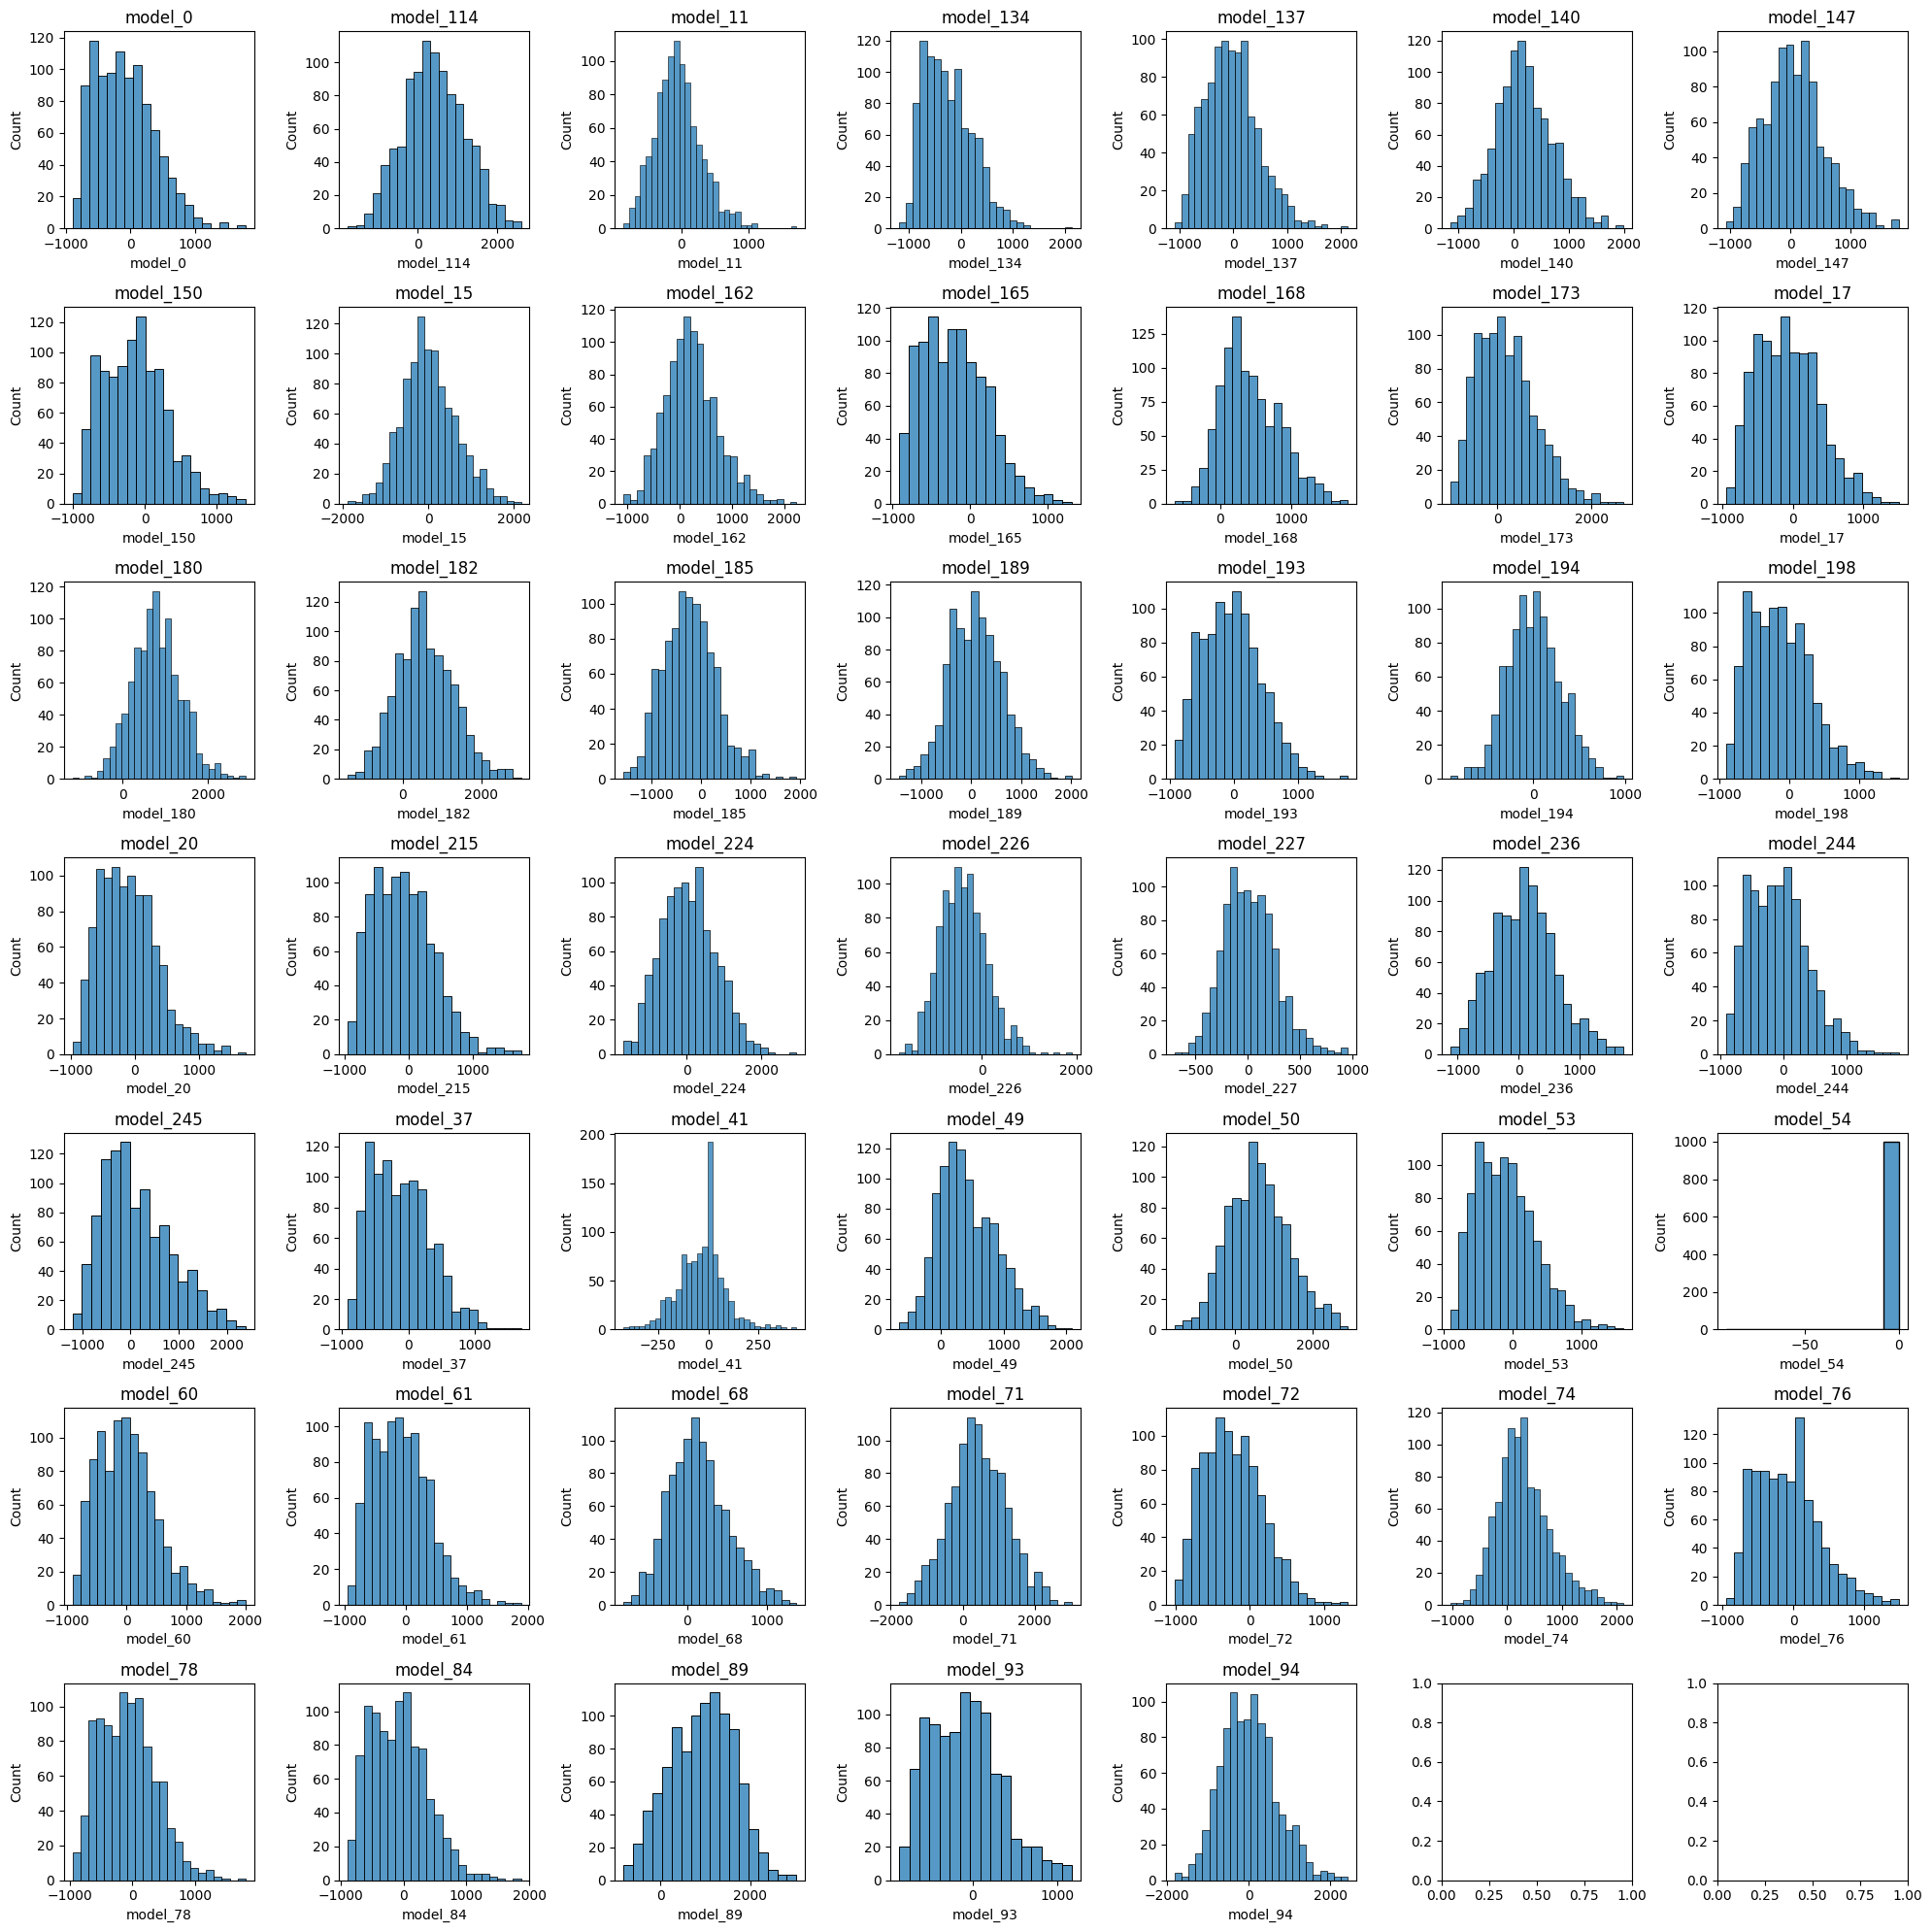

In [34]:
# Create a grid of subplots for every column in df where there are 7 rows and 7 columns that show the distribution of the data

# Create a grid of subplots
fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(20, 20))

# Flatten the axs array
axs = axs.flatten()

# Iterate over the columns in df
for i, col in enumerate(df.columns):
    # Plot the distribution of the column
    sns.histplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [3]:
# save the df
# df.to_csv('C:/Users/WilliamFetzner/Documents/Trading/models_2024-05-17/models_df_best_results.csv')
df = pd.read_csv('C:/Users/WilliamFetzner/Documents/Trading/models_2024-05-17/models_df_best_results.csv', index_col=0)
df

,model_0,model_114,model_11,model_134,model_137,model_140,model_147,model_150,model_15,model_162,...,model_68,model_71,model_72,model_74,model_76,model_78,model_84,model_89,model_93,model_94
0,245.200500,-268.943227,-383.124236,77.170269,-403.149172,500.070316,59.071981,-448.991383,-8.089164,74.222373,...,660.872300,934.441858,-922.816178,647.262771,557.558144,-418.518014,198.626634,-272.518763,-490.233906,-493.431796
1,-460.115938,-597.731781,257.601029,-342.175901,-723.800590,-150.401316,-26.431722,61.417471,-692.028674,508.308065,...,-150.224546,-341.135605,-508.416133,934.675750,-167.445864,58.639371,-584.722566,1370.993578,-24.034553,824.708852
2,-247.261536,848.988307,-585.590812,121.224041,-307.308180,493.285688,-420.867562,19.973494,-687.851092,-623.483870,...,25.336419,801.758433,-145.098056,-13.768192,-543.508146,66.171344,22.757443,1465.950941,-624.643689,-238.189810
3,-395.416708,1165.196670,823.112498,-272.158079,-876.706934,85.594612,-2.155340,-281.266220,611.937926,-41.935592,...,-163.287892,1665.690579,-270.058372,490.577359,782.191882,280.204601,-245.139708,222.083960,-106.325933,388.725747
4,-22.366730,465.159286,12.263873,499.808738,-649.811324,614.156292,-293.424875,-549.944245,-356.980120,220.731339,...,535.192424,1220.608521,159.168721,232.707394,-222.717476,-142.601812,-14.253378,1193.839400,-59.947731,516.281414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,131.611055,70.222577,42.799049,281.079306,424.799179,163.221518,327.557627,-738.361039,703.782287,128.116793,...,2.322558,144.621418,-629.443156,365.435526,-480.560496,-169.344149,172.714083,707.455690,-293.375646,-391.036881
996,52.114670,1711.571719,474.194812,538.606460,162.045413,979.170059,-336.726366,579.338589,736.085403,399.988879,...,25.423695,-352.924778,-421.287238,138.390690,-649.652964,-530.197594,-149.930066,-11.970608,-289.688219,-339.399451
997,-401.872588,-785.944715,119.236145,-422.818904,74.980879,-8.258029,203.668678,-219.220989,-418.213650,59.850549,...,76.203461,-334.382571,-572.598477,445.278325,-643.566182,-353.377331,-353.736305,2050.850477,-387.133814,-460.360825
998,-0.825629,-306.105799,-614.448118,-189.836352,192.869757,-549.332766,397.468153,-0.092729,129.083511,148.633896,...,594.583557,46.985231,355.536292,-580.691481,-136.536632,-180.664706,139.929643,575.689293,129.254123,432.862673


In [13]:
# find the median for all the columns in df
median_df = df.median(axis=0)
# put it back into a dataframe
median_df = pd.DataFrame(median_df)
# rename the column
median_df = median_df.rename(columns={0: 'median'})
median_df

,median
model_0,-141.430707
model_114,373.044871
model_11,-67.624484
model_134,-298.246298
model_137,-64.036837
model_140,154.849399
model_147,36.640931
model_150,-153.010353
model_15,-25.115591
model_162,183.526786


In [5]:
type(median_df)

pandas.core.series.Series

In [6]:
# Assuming df is your DataFrame with columns ['Group1', 'Group2', 'Group3']
reshaped_df = df.melt(var_name='Models', value_name='Profits')

# Display reshaped DataFrame
print(reshaped_df.head())

    Models     Profits
0  model_0  245.200500
1  model_0 -460.115938
2  model_0 -247.261536
3  model_0 -395.416708
4  model_0  -22.366730


In [7]:
# Extract measurements for each group
groups = reshaped_df.groupby('Models')['Profits'].apply(lambda x: x.tolist())

# Perform Kruskal-Wallis test
stat, p = kruskal(*groups)

print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=8614.847, p=0.000


In [8]:
from scipy.stats import ranksums
from itertools import combinations

# Get unique groups
unique_groups = reshaped_df['Models'].unique()

# Initialize a dictionary to hold p-values
pvalues = {}

# Perform Dunn's test for each pair of groups
for group1, group2 in combinations(unique_groups, 2):
    # Extract measurements for each group
    measurements1 = reshaped_df.loc[reshaped_df['Models'] == group1, 'Profits'].values
    measurements2 = reshaped_df.loc[reshaped_df['Models'] == group2, 'Profits'].values
    
    # Perform rank sum test
    stat, p = ranksums(measurements1, measurements2)
    
    # Apply Bonferroni correction for multiple comparisons
    corrected_p = p * len(list(combinations(unique_groups, 2)))
    
    # Store the result
    pvalues[(group1, group2)] = corrected_p

# Print p-values
for pair, pvalue in pvalues.items():
    if pvalue < 0.05:
        print(f"P-value for {pair}: {pvalue}")

P-value for ('model_0', 'model_114'): 2.574599902865872e-58
P-value for ('model_0', 'model_134'): 8.851481075120929e-11
P-value for ('model_0', 'model_140'): 2.37845891661147e-33
P-value for ('model_0', 'model_147'): 1.3310258856320959e-08
P-value for ('model_0', 'model_162'): 2.3381233441582805e-42
P-value for ('model_0', 'model_165'): 0.0005653913542364703
P-value for ('model_0', 'model_168'): 3.808792105656439e-116
P-value for ('model_0', 'model_173'): 5.3338359909261e-21
P-value for ('model_0', 'model_180'): 2.0228424567270816e-195
P-value for ('model_0', 'model_182'): 8.204424525844796e-98
P-value for ('model_0', 'model_185'): 1.0202429457400974e-06
P-value for ('model_0', 'model_189'): 2.9366246053113747e-13
P-value for ('model_0', 'model_194'): 4.943546795243698e-10
P-value for ('model_0', 'model_224'): 0.003349929110350634
P-value for ('model_0', 'model_226'): 2.724894545436256e-38
P-value for ('model_0', 'model_227'): 4.622331759482843e-12
P-value for ('model_0', 'model_236'):

In [9]:
significant = {}
for pair, pvalue in pvalues.items():
    if pvalue < 0.05:
        significant[pair] = pvalue
        print(f"P-value for {pair}: {pvalue}")

P-value for ('model_0', 'model_114'): 2.574599902865872e-58
P-value for ('model_0', 'model_134'): 8.851481075120929e-11
P-value for ('model_0', 'model_140'): 2.37845891661147e-33
P-value for ('model_0', 'model_147'): 1.3310258856320959e-08
P-value for ('model_0', 'model_162'): 2.3381233441582805e-42
P-value for ('model_0', 'model_165'): 0.0005653913542364703
P-value for ('model_0', 'model_168'): 3.808792105656439e-116
P-value for ('model_0', 'model_173'): 5.3338359909261e-21
P-value for ('model_0', 'model_180'): 2.0228424567270816e-195
P-value for ('model_0', 'model_182'): 8.204424525844796e-98
P-value for ('model_0', 'model_185'): 1.0202429457400974e-06
P-value for ('model_0', 'model_189'): 2.9366246053113747e-13
P-value for ('model_0', 'model_194'): 4.943546795243698e-10
P-value for ('model_0', 'model_224'): 0.003349929110350634
P-value for ('model_0', 'model_226'): 2.724894545436256e-38
P-value for ('model_0', 'model_227'): 4.622331759482843e-12
P-value for ('model_0', 'model_236'):

In [20]:
# create a dataframe from the siginificant dictionary
significant_df = pd.DataFrame.from_dict(significant, orient='index', columns=['p-value']).reset_index().rename(columns={'index': 'models'})
# split the tuple in the 'models' column into two columns
significant_df[['model_0', 'model_1']] = significant_df['models'].apply(lambda x: pd.Series(str(x).split(',')))
# remove the tuple parentheses from the 'model_0' and 'model_1' columns and the "'" 
significant_df['model_0'] = significant_df['model_0'].str.strip('()').str.strip("'")
significant_df['model_1'] = significant_df['model_1'].str.strip('()').str.strip("'")
significant_df


,models,p-value,model_0,model_1
0,"(model_0, model_114)",2.574600e-58,model_0,'model_114
1,"(model_0, model_134)",8.851481e-11,model_0,'model_134
2,"(model_0, model_140)",2.378459e-33,model_0,'model_140
3,"(model_0, model_147)",1.331026e-08,model_0,'model_147
4,"(model_0, model_162)",2.338123e-42,model_0,'model_162
...,...,...,...,...
798,"(model_76, model_89)",1.831082e-182,model_76,'model_89
799,"(model_78, model_89)",7.080214e-182,model_78,'model_89
800,"(model_84, model_89)",9.766305e-183,model_84,'model_89
801,"(model_89, model_93)",3.039995e-186,model_89,'model_93


In [22]:
# join the median_df with the significant_df on the model_0 column
significant_df_joined = pd.merge(significant_df, median_df, left_on='model_0', right_on=median_df.index)
significant_df_joined = significant_df_joined.rename(columns={'median': 'model_0_median'})
significant_df_joined.insert(4, "model_1_fixed", significant_df_joined["model_1"].str.replace(" '", ""))
# drop model_1 column
significant_df_joined = significant_df_joined.drop(columns=['model_1'])
significant_df_joined2 = pd.merge(significant_df_joined, median_df, left_on='model_1_fixed', right_on=median_df.index)
significant_df_joined2 = significant_df_joined2.rename(columns={'median': 'model_1_median'})
significant_df_joined2

,models,p-value,model_0,model_1_fixed,model_0_median,model_1_median
0,"(model_0, model_114)",2.574600e-58,model_0,model_114,-141.430707,373.044871
1,"(model_0, model_134)",8.851481e-11,model_0,model_134,-141.430707,-298.246298
2,"(model_114, model_134)",4.101036e-92,model_114,model_134,373.044871,-298.246298
3,"(model_11, model_134)",2.447896e-27,model_11,model_134,-67.624484,-298.246298
4,"(model_0, model_140)",2.378459e-33,model_0,model_140,-141.430707,154.849399
...,...,...,...,...,...,...
798,"(model_68, model_94)",8.123644e-09,model_68,model_94,112.227147,-43.092335
799,"(model_71, model_94)",5.795749e-32,model_71,model_94,384.846619,-43.092335
800,"(model_72, model_94)",2.555429e-13,model_72,model_94,-272.780541,-43.092335
801,"(model_74, model_94)",7.569568e-29,model_74,model_94,256.193533,-43.092335


In [38]:
# add 'model_' to the values in best_hyperparameters_current_week_success_negative_index_reset['models']
best_hyperparameters_current_week_success_negative_index_reset.loc[:,'models_rank'] = best_hyperparameters_current_week_success_negative_index_reset['models_rank'].apply(lambda x: 'model_' + str(x))
best_hyperparameters_current_week_success_negative_index_reset2 = best_hyperparameters_current_week_success_negative_index_reset.reset_index()
# rename index to 'rank'
best_hyperparameters_current_week_success_negative_index_reset2 = best_hyperparameters_current_week_success_negative_index_reset2.rename(columns={'index': 'rank'})
best_hyperparameters_current_week_success_negative_index_reset2

,rank,models_rank,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,0,model_224,-1177.829891,ok,0.026460,0.001137,0.941669,24.8,1.929034
1,1,model_114,-861.134723,ok,0.032388,0.000059,0.935070,2.0,0.033623
2,2,model_89,-678.911910,ok,0.031810,0.004452,0.943984,48.2,0.537641
3,3,model_180,-653.672668,ok,0.018963,0.000079,0.932250,108.2,0.281889
4,4,model_60,-545.591384,ok,0.027795,0.002588,0.935848,26.3,0.596425
...,...,...,...,...,...,...,...,...,...
61,61,model_197,-5.636681,ok,0.024878,0.027399,0.928146,38.9,0.007843
62,62,model_113,-5.636681,ok,0.024363,0.037461,0.949387,38.9,0.007843
63,63,model_229,-5.636681,ok,0.022883,0.048445,0.952559,38.9,0.007843
64,64,model_75,-5.636681,ok,0.032488,0.000956,0.946843,38.9,0.007843


In [39]:
best_hyperparameters_current_week_success_negative_index_reset2_ranks = best_hyperparameters_current_week_success_negative_index_reset2[['models_rank', 'rank']]
best_hyperparameters_current_week_success_negative_index_reset2_ranks

,models_rank,rank
0,model_224,0
1,model_114,1
2,model_89,2
3,model_180,3
4,model_60,4
...,...,...
61,model_197,61
62,model_113,62
63,model_229,63
64,model_75,64


In [41]:
# filter best_hyperparameters_current_week_success_negative_index_reset2_ranks to just what is in significant_df.model_0
best_hyperparameters_current_week_success_negative_index_reset2_ranks_fil = best_hyperparameters_current_week_success_negative_index_reset2_ranks[
    best_hyperparameters_current_week_success_negative_index_reset2_ranks['models_rank'].isin(significant_df_joined2['model_0'])]
significant_df_joined3 = pd.merge(significant_df_joined2, best_hyperparameters_current_week_success_negative_index_reset2_ranks_fil, left_on='model_0', right_on='models_rank')
# rename the rank column to model_0_rank
significant_df_joined3 = significant_df_joined3.rename(columns={'rank': 'model_0_rank'})
significant_df_joined4 = pd.merge(significant_df_joined3, best_hyperparameters_current_week_success_negative_index_reset2_ranks_fil, left_on='model_1_fixed', right_on='models_rank')
# rename the rank column to model_1_rank
significant_df_joined4 = significant_df_joined4.rename(columns={'rank': 'model_1_rank'})
significant_df_joined4

,models,p-value,model_0,model_1_fixed,model_0_median,model_1_median,models_rank_x,model_0_rank,models_rank_y,model_1_rank
0,"(model_0, model_114)",2.574600e-58,model_0,model_114,-141.430707,373.044871,model_0,45,model_114,1
1,"(model_0, model_134)",8.851481e-11,model_0,model_134,-141.430707,-298.246298,model_0,45,model_134,17
2,"(model_114, model_134)",4.101036e-92,model_114,model_134,373.044871,-298.246298,model_114,1,model_134,17
3,"(model_11, model_134)",2.447896e-27,model_11,model_134,-67.624484,-298.246298,model_11,35,model_134,17
4,"(model_0, model_140)",2.378459e-33,model_0,model_140,-141.430707,154.849399,model_0,45,model_140,10
...,...,...,...,...,...,...,...,...,...,...
751,"(model_54, model_84)",6.308934e-09,model_54,model_84,0.000000,-99.510674,model_54,14,model_84,32
752,"(model_68, model_84)",2.841057e-31,model_68,model_84,112.227147,-99.510674,model_68,26,model_84,32
753,"(model_71, model_84)",3.340089e-56,model_71,model_84,384.846619,-99.510674,model_71,11,model_84,32
754,"(model_72, model_84)",7.676103e-10,model_72,model_84,-272.780541,-99.510674,model_72,20,model_84,32


# try to determine if the models with lower rankings are more often significantly idfferent from the models that have higher rankings

In [ ]:
# create a new column that is 1 if model_0_median is greater than model_1_median
significant_df_joined2['model_0_is_greater'] = significant_df_joined2['model_0_median'] > significant_df_joined2['model_1_median']
# do the same for model_1_median
significant_df_joined2['model_1_is_greater'] = significant_df_joined2['model_1_median'] > significant_df_joined2['model_0_median']


In [35]:
len(significant_df)

803

In [34]:
# is 224 in significant_df['model_0'] or significant_df['model_1'] and how many times?
significant_df[significant_df['model_0'].isin(['model_224']) | significant_df['model_1'].str.contains('224')]

,models,p-value,model_0,model_1
13,"(model_0, model_224)",3.349929e-03,model_0,'model_224
48,"(model_114, model_224)",6.768403e-23,model_114,'model_224
114,"(model_134, model_224)",8.621414e-20,model_134,'model_224
172,"(model_140, model_224)",2.285944e-04,model_140,'model_224
232,"(model_150, model_224)",2.908301e-07,model_150,'model_224
279,"(model_162, model_224)",5.014966e-07,model_162,'model_224
311,"(model_165, model_224)",4.659512e-14,model_165,'model_224
344,"(model_168, model_224)",2.098435e-38,model_168,'model_224
420,"(model_180, model_224)",5.977544e-109,model_180,'model_224
451,"(model_182, model_224)",9.746114e-46,model_182,'model_224


In [17]:
best_hyperparameters_current_week_success_negative_index_reset

,models,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,224,-1177.829891,ok,0.026460,0.001137,0.941669,24.8,1.929034
1,114,-861.134723,ok,0.032388,0.000059,0.935070,2.0,0.033623
2,89,-678.911910,ok,0.031810,0.004452,0.943984,48.2,0.537641
3,180,-653.672668,ok,0.018963,0.000079,0.932250,108.2,0.281889
4,60,-545.591384,ok,0.027795,0.002588,0.935848,26.3,0.596425
...,...,...,...,...,...,...,...,...
61,197,-5.636681,ok,0.024878,0.027399,0.928146,38.9,0.007843
62,113,-5.636681,ok,0.024363,0.037461,0.949387,38.9,0.007843
63,229,-5.636681,ok,0.022883,0.048445,0.952559,38.9,0.007843
64,75,-5.636681,ok,0.032488,0.000956,0.946843,38.9,0.007843


In [16]:
pvalues

{('model_0', 'model_114'): 2.574599902865872e-58,
 ('model_0', 'model_11'): 0.24904063116848793,
 ('model_0', 'model_134'): 8.851481075120929e-11,
 ('model_0', 'model_137'): 7.294901761559377,
 ('model_0', 'model_140'): 2.37845891661147e-33,
 ('model_0', 'model_147'): 1.3310258856320959e-08,
 ('model_0', 'model_150'): 30.071000330391595,
 ('model_0', 'model_15'): 0.0542115351943561,
 ('model_0', 'model_162'): 2.3381233441582805e-42,
 ('model_0', 'model_165'): 0.0005653913542364703,
 ('model_0', 'model_168'): 3.808792105656439e-116,
 ('model_0', 'model_173'): 5.3338359909261e-21,
 ('model_0', 'model_17'): 171.84093301086833,
 ('model_0', 'model_180'): 2.0228424567270816e-195,
 ('model_0', 'model_182'): 8.204424525844796e-98,
 ('model_0', 'model_185'): 1.0202429457400974e-06,
 ('model_0', 'model_189'): 2.9366246053113747e-13,
 ('model_0', 'model_193'): 2.7759691358800085,
 ('model_0', 'model_194'): 4.943546795243698e-10,
 ('model_0', 'model_198'): 258.1964083131921,
 ('model_0', 'model_2

In [ ]:
# determine if there is a significant difference between any of the columns in df
def pairwise_ttests(df):
    pairs = []
    p_values = []

    # Generate all unique pairs of columns
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            pairs.append((df.columns[i], df.columns[j]))

    # Perform t-tests for each pair
    for pair in pairs:
        t_stat, p_value = ttest_ind(df[pair[0]], df[pair[1]])
        p_values.append(p_value)

    # Create a DataFrame to store results
    results_df = pd.DataFrame({
        'Pair': pairs,
        'P-value': p_values
    })

    return results_df

results = pairwise_ttests(df)
print(results)